In [ ]:
#Add google drive
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
#Add link to shared cross section library
#shared library was added as a shortcut to My Drive from the web interface
%env OPENMC_CROSS_SECTIONS = /gdrive/My Drive/data/endfb71_hdf5/cross_sections.xml

In [ ]:
#Download miniconda and install
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
# Install OpenMC
!conda config --add channels conda-forge
!conda install openmc -y

In [1]:
import openmc

In [2]:
%matplotlib inline

Define the materials

In [3]:
#inner_fuel_zone_per = {'U235': 0.0019, 'U238': 0.7509, 'Pu238': 0.0046, 'Pu239': 0.0612, 'Pu240': 0.0383, 'Pu241': 0.0106, 'Pu242': 0.0134, 'Am241': 0.001, 'O16': 0.1181}
#outer_fuel_zone_per = {'U235': 0.0018, 'U238': 0.73, 'Pu238': 0.0053, 'Pu239': 0.0711, 'Pu240': 0.0445, 'Pu241': 0.0124, 'Pu242': 0.0156, 'Am241': 0.0017, 'O16': 0.1175}
#reflector_fuel_zone_per = {'Na23':0.5, 'F19':0.5}
#input density#####10g/cc for most cases; .96g/cc for liquid sodium 

# inner
u235 = openmc.Material(name='U235')
u235.set_density('g/cm3', 10.0)
u235.add_nuclide('U235', 1.0)

u238 = openmc.Material(name='U238')
u238.set_density('g/cm3', 10.0)
u238.add_nuclide('U238', 1.0)

pu238 = openmc.Material(name='Pu238')
pu238.set_density('g/cm3', 10.0)
pu238.add_nuclide('U238', 1.0)

pu239 = openmc.Material(name='U235')
pu239.add_nuclide('Pu239', 1.0)
pu239.set_density('g/cm3', 10.0)

pu240 = openmc.Material(name = 'pu240')
pu240.add_nuclide('Pu240', 1.0)
pu240.set_density('g/cm3', 10.0)

pu241 = openmc.Material(name = 'pu241')
pu241.add_nuclide('Pu241', 1.0)
pu241.set_density('g/cm3', 10.0)

pu242 = openmc.Material(name = 'pu242')
pu242.add_nuclide('Pu242', 1.0)
pu242.set_density('g/cm3', 10.0)

am241 = openmc.Material(name = 'am241')
am241.add_nuclide('Am241', 1.0)
am241.set_density('g/cm3', 10.0)

o16 = openmc.Material(name = 'o16')
o16.add_nuclide('O16', 1.0)
o16.set_density('g/cm3', 10.0)

#gap (liquid sodium?) Sodium gap width inter assembly	0.45 cm
sodium = openmc.Material(name='sodium')
sodium.set_density('g/cm3', 0.96)
sodium.add_nuclide('Na23', 1.0)

#clad (ODS steel); 99.7 wt% (99.3 vol%) Cu, 0.3 wt% (0.7 vol%) Al2O3

cu63 = openmc.Material(name= 'cu63')
cu63.set_density('g/cm3', 10.0)
cu63.add_nuclide('Cu63', 1.0)

Al2O3 = openmc.Material(name='Al2O3')
Al2O3.set_density('g/cm3', 10.0)
Al2O3.add_element('O', 3.0)
Al2O3.add_element('Al', 2.0)

#moderator, liquid sodium?

Use the materials defined above to make material mixtures.

In [4]:
inner = openmc.Material.mix_materials([u235, u238, pu238, pu239, pu240, pu241, pu242, am241, o16],[0.0019, 0.7509, 0.0046, 0.0612, 0.0383, 0.0106, 0.0134, 0.001, 0.1181],'wo')
outer = openmc.Material.mix_materials([u235, u238, pu238, pu239, pu240, pu241, pu242, am241, o16],[0.0018, 0.73, 0.0053, 0.0711, 0.0445, 0.0124, 0.0156, 0.0017, 0.1176],'wo')
clad = openmc.Material.mix_materials([cu63,Al2O3],[0.997,0.003],'wo')

In [5]:
materials_file = openmc.Materials([inner, outer, sodium, clad])
materials_file.export_to_xml()
#!cat materials.xml

Now, we being to define the geometry. First, we will make a few general geometry features that will be used many times: the fuel cylinder, the top & bottom of the geometry, etc. 

In [6]:
fuel_or = openmc.ZCylinder(surface_id=1, r=0.943/2) 
clad_ir = openmc.ZCylinder(surface_id=2, r=0.973/2) 
clad_or = openmc.ZCylinder(surface_id=3, r=1.073/2) 

# Active height 100cm
top    = openmc.ZPlane(surface_id=4, z0=+50, boundary_type='vacuum')
bottom = openmc.ZPlane(surface_id=5, z0=-50, boundary_type='vacuum') 

fuel_region = -fuel_or & -top & +bottom
gap_region  = +fuel_or & -clad_ir  & -top & +bottom
clad_region = +clad_ir & -clad_or  & -top & +bottom
moderator_region = +clad_or & -top & +bottom
 
gap_cell    = openmc.Cell(cell_id=1, fill=inner,  region=gap_region)
clad_cell   = openmc.Cell(cell_id=2, fill=clad,   region=clad_region)
sodium_cell = openmc.Cell(cell_id=3, fill=sodium, region=moderator_region)

Now let's begin with the fuel universe for the inner core. This fuel universe has the "inner" fuel material which is a unique fuel mixture.

In [7]:
inner_fuel_cell = openmc.Cell(cell_id=4, fill=inner, region=fuel_region)
inner_u = openmc.Universe(universe_id=1, cells=(inner_fuel_cell, gap_cell, clad_cell, sodium_cell))

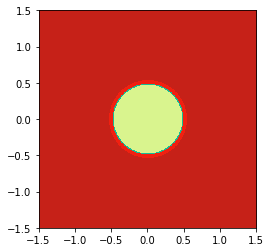

In [8]:
inner_u.plot(pixels=(500, 500), width = (3,3))

Now let's follow up with the fuel universe for the outer core. This fuel universe has the "outer" fuel material which is a unique fuel mixture.

In [9]:
outer_fuel_cell = openmc.Cell(cell_id=5, fill=outer, region=fuel_region)
outer_u = openmc.Universe(universe_id=2, cells=(outer_fuel_cell, gap_cell, clad_cell, sodium_cell))

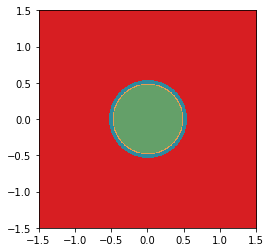

In [10]:
outer_u.plot(pixels=(500, 500), width=(3,3))

We have inner fuel and outer fuel universes defined, so now we can create assemblies that are filled with either one. 

In [11]:
# Creating a filling that will surround any emtpy space in the core
sodium_mod_cell = openmc.Cell(cell_id=6, fill=sodium)
sodium_mod_u = openmc.Universe(universe_id=3, cells=(sodium_mod_cell,))

# Define a lattice
in_lat = openmc.HexLattice(lattice_id=1, name='inner assembly')
in_lat.center = (0., 0.)
in_lat.pitch = (21.08/17,) #in cm, 21.08 is pitch of assembly filled into full core
in_lat.orientation = 'x'
in_lat.outer = sodium_mod_u
#print(lat.show_indices(9))

# Create rings of fuel universes that will fill the lattice
inone = [inner_u]*48
intwo = [inner_u]*42
inthree = [inner_u]*36
infour = [inner_u]*30
infive = [inner_u]*24
insix = [inner_u]*18
inseven = [inner_u]*12
ineight = [inner_u]*6
innine = [inner_u]*1
in_lat.universes = [inone,intwo,inthree,infour,infive,insix,inseven,ineight,innine]

# Create the prism that will contain the lattice
outer_in_surface = openmc.model.hexagonal_prism(edge_length=12.1705, orientation='x')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
main_in_assembly = openmc.Cell(cell_id=7, fill=in_lat, region=outer_in_surface & -top & +bottom)

# Fill a cell with a material that will surround the lattice
out_in_assembly  = openmc.Cell(cell_id=8, fill=sodium, region=~outer_in_surface & -top & +bottom)

# Create a universe that contains both 
main_in_u = openmc.Universe(universe_id=4, cells=[main_in_assembly, out_in_assembly])

/Users/miriamrathbun/codes/openmc-mak/openmc/mixin.py:68: IDWarning: Another Lattice instance already exists with id=1.
  warn(msg, IDWarning)


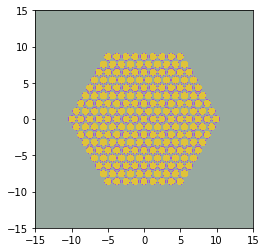

In [12]:
main_in_u.plot(origin = (0,0,0), pixels=(500, 500), width = (30.,30.), color_by = 'material')

Let's do the exact same thing again, this time the assembly lattice will be full of outer fuel universes.

In [13]:
# Define a lattice
out_lat = openmc.HexLattice(lattice_id=2, name='outer assembly')
out_lat.center = (0., 0.)
out_lat.pitch = (21.08/17,) #in cm, 21.08 is pitch of assembly filled into full core
out_lat.orientation = 'x'
out_lat.outer = sodium_mod_u
#print(lat.show_indices(9))

# Create rings of fuel universes that will fill the lattice
outone = [outer_u]*48
outtwo = [outer_u]*42
outthree = [outer_u]*36
outfour = [outer_u]*30
outfive = [outer_u]*24
outsix = [outer_u]*18
outseven = [outer_u]*12
outeight = [outer_u]*6
outnine = [outer_u]*1
out_lat.universes = [outone,outtwo,outthree,outfour,outfive,outsix,outseven,outeight,outnine]

# Create the prism that will contain the lattice
outer_out_surface = openmc.model.hexagonal_prism(edge_length=12.1705)

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
main_out_assembly = openmc.Cell(cell_id=9,  fill=out_lat, region=outer_out_surface & -top & +bottom)

# Fill a cell with a material that will surround the lattice
out_out_assembly  = openmc.Cell(cell_id=10, fill=sodium,  region=~outer_out_surface & -top & +bottom)

# Create a universe that contains both 
main_out_u = openmc.Universe(universe_id=5, cells=[main_out_assembly, out_out_assembly])

/Users/miriamrathbun/codes/openmc-mak/openmc/mixin.py:68: IDWarning: Another Lattice instance already exists with id=2.
  warn(msg, IDWarning)


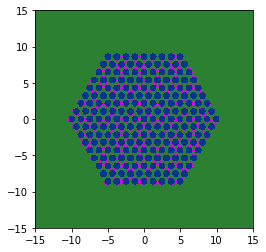

In [14]:
main_out_u.plot(origin = (0,0,0), pixels=(500, 500), width = (30.,30.), color_by = 'material')

The last type of assembly we need it a reflector assembly. This is really just a cell that's 100% full of reflector material. So there is no need to make a lattice. We just have a prism that is full of sodium.

In [15]:
reflector_assembly = openmc.model.hexagonal_prism(edge_length=12.1705, orientation='x')
ref_cell = openmc.Cell(cell_id=11, fill=sodium, region=reflector_assembly & -top & +bottom)
out_ref_cell  = openmc.Cell(cell_id=12, fill=sodium, region=~reflector_assembly & -top & +bottom)
ref_u = openmc.Universe(universe_id=6, cells=[ref_cell, out_ref_cell])

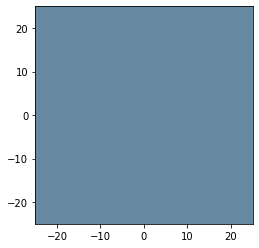

In [16]:
ref_u.plot(origin = (0,0,0), width = (50.,50.), color_by = 'material')

We now have 3 types of assemblies created! We can now make the entire reactor core by creating a lattice that is filled with the assemblies. 

In [17]:
# Define the lattice
core_lat = openmc.HexLattice(lattice_id=3, name='core')
core_lat.center = (0., 0.)
core_lat.pitch = (21.08,) #in cm, 21.08 is pitch of assembly filled into full core
core_lat.outer = sodium_mod_u
#print(lat.show_indices(17))

/Users/miriamrathbun/codes/openmc-mak/openmc/mixin.py:68: IDWarning: Another Lattice instance already exists with id=3.
  warn(msg, IDWarning)


In [18]:
# Create rings of fuel universes that will fill the lattice
ref_one = [ref_u] * 96
ref_two = [ref_u] * 90
ref_three = [ref_u] * 84
ref_four = ([ref_u] * 5 + [main_out_u] * 4 + [ref_u] * 4) * 6
ref_five = ([ref_u] + [main_out_u] * 11) * 6
out_one = [main_out_u]*66
out_two = [main_out_u]*60
out_three = ([main_out_u]*2 + [main_in_u]*6 + [main_out_u] * 1)*6
in_one = [main_in_u]*48
in_two = [main_in_u]*42
in_three = [main_in_u]*36
in_four = [main_in_u]*30
in_five = [main_in_u]*24
in_six = [main_in_u]*18
in_seven = [main_in_u]*12
in_eight = [main_in_u]*6
in_nine = [main_in_u]*1
core_lat.universes = [ref_one,ref_two,ref_three,ref_four,ref_five,out_one,out_two,out_three,in_one,in_two,in_three,in_four,in_five,in_six,in_seven,in_eight,in_nine]

In [19]:
# Create the prism that will contain the lattice
outer_core_surface = openmc.model.hexagonal_prism(edge_length=347.82, boundary_type='vacuum')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
core = openmc.Cell(cell_id=13, fill=core_lat, region=outer_core_surface & -top & +bottom)

# Fill a cell with a material that will surround the lattice
out_core = openmc.Cell(cell_id=14, fill=outer, region=~outer_core_surface & -top & +bottom)

# Create a universe that contains both 
main_u = openmc.Universe(universe_id=7, cells=[core, out_core]) 

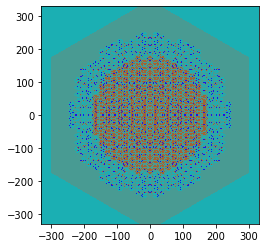

In [20]:
main_u.plot(origin = (0,0,0), pixels=(1000, 1000), width = (660.,660.), color_by = 'material')

We now have an entire reactor core defined! We can export the geometry and run the code. 

In [21]:
geom = openmc.Geometry(main_u)
geom.export_to_xml()

In [22]:
lower_left = [-300, -300, -50]
upper_right = [300, 300, 50]
uniform_dist = openmc.stats.Box(lower_left, upper_right, only_fissionable=True)
src = openmc.Source(space=uniform_dist)

settings = openmc.Settings()
settings.source = src
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

settings.export_to_xml()
# !cat settings.xml

In [23]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################